# Impressão 3D de um rato a partir de imagens de tomografia

**Grupo:**
* Julio Stein
* Rafael Riciardi Barreira
* Thiago Kenzo Fujioka Shida

**Objetivo:**
<P>
Para suprir as necessidades em pesquisas de ressonância magnética fazendo testes em animais como em ratos de laboratório, tem se buscado substituir os animais por modelos, como a utilização de phantoms que aproxime as características e propriedades do animal real, imitando o comportamento de suas características na aquisição de imagens.<P>
Assim, o objetivo do projeto é conseguir gerar um modelo a partir de imagens da ressonancia magnética de um rato, aplicando ténicas de processamento de imagens, geração de STL com a construção do mesh e impressão 3D do mesmo.

### Pacotes Utilizados

In [1]:
import os
import cv2
import gdcm
import pydicom
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from dicom2stl.examples import gui
from dicom2stl.utils import vtkutils
from dicom2stl.examples.myshow import myshow, myshow3d

from pydicom import dcmread
from pydicom.data import get_testdata_file
from pydicom.uid import ExplicitVRLittleEndian

from skimage import feature, filters
from skimage.filters import roberts, sobel, scharr, prewitt

from scipy import ndimage
#from PIL import Image, ImageFilter
from IPython.display import Image, Video

import itkwidgets

%load_ext autoreload
%autoreload 1

In [2]:
%matplotlib notebook

## Importando e analisando as imagens originais

Para auxiliar na visualização das imagens, aproveitamos uma implementação de um GIT para exibição de imagens multiplas DICOM como uma GUI que nos permite navegar entre elas de forma simples e intuitiva, bem como aplicar um pré-filtro de intensidade dos pixels.

In [3]:
path = "pos_twist_05iso_37"

In [4]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(path)
reader.SetFileNames(dicom_names)
original_image = reader.Execute()

size = original_image.GetSize()
size

(192, 512, 120)

<IPython.core.display.Javascript object>


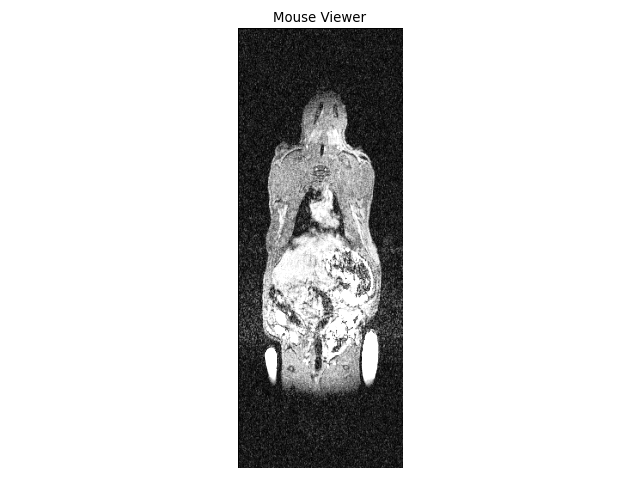

In [5]:
gui.MultiImageDisplay(image_list=[original_image], title_list=['Mouse Viewer'], figure_size=(8,6))

Pela visualização acima, podemos perceber o alto nível de ruído nas imagens originais e durante o projeto percebemos que isso impactava bastante a geração do mesh nas etapas posteriores. Além disso, também notamos que as extremidades com contornos não tão bem definidos e alguns locais muito detalhados, também prejudicavam o resultado final, e por isso aplicamos alguns filtros e processamentos nas imagens.

## Filtrando as imagens

Nessa etapa, o primeiro grande desafio foi justamente aprender a trabalhar e manipular as propriedades das imagens DICOM, para uma vez que tivessemos aplicado algum filtro, pudessemos salvá-la com sucesso. Após aprender algumas particularidades sobre o formato, criamos a função **save_dicom_file**. Que recebe o arquivo DICOM original da imagem, o novo array e o caminho a ser salvo. Além disso, para que possa ser salvo, temos que alterar também a propriedade TransferSyntaxUID, que para uma mais permissiva às alterações.
<br>
Além disso, aplicamos os seguintes filtros:
* `intensity_filter:` Com base na pré-visualização das imagens, percebemos que filtrar os pixels com intensidade inferiores a 75 ajudava bastante no ruído original. Então, criamos essa função que transforma todos os pixels menores ou iguals a 75 em 0. 
* `erosion:` Remove alguns pixels das camadas nas partes de contorno internas e externas da imagem, aumentando os buracos e espaçamentos das regiões e removendo pequenos detalhes. Além de remover os detalhes que prejudicavam a construção do mesh, foi bem útil também para remoção dos ruídos restantes.
* `dilatation:` Realiza justamente o processo inverso da erosão, adicionando pixels às partes de contorno internas e externas da imagem. No caso, o tamanho do filtro aplicado na dilatação foi maior, pois percebemos que melhorava a reconstrução da imagem no sentido de fazê-la com ainda menos detalhes nos contornos, o que beneficiava o mesh gerado posteriormente.
* `noise_filter:`

In [52]:
!rd /s /q "filter_images/"
!mkdir filter_images

In [53]:
def save_dicom_file(original_file, new_array, file_path):

    original_file.file_meta.TransferSyntaxUID = ExplicitVRLittleEndian
    original_file.PixelData = new_array.tobytes()
    original_file.save_as(file_path)

In [162]:
def intensity_filter(pixel_array, value=75):
    pixel_array = np.array(pixel_array)
    pixel_array[pixel_array<=value] = 0
    return pixel_array

def noise_filter(img):
    img = np.array(img)
    w = np.ones([5,5])/25
    Im_filter = ndimage.convolve(img,w, mode='reflect')
    return Im_filter

def erosion(img):
    kernel = np.ones((5,5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=1)
    
    return img_erosion

def dilatation(img):
    kernel = np.ones((10,10), np.uint8)
    img_dilation = cv2.dilate(img, kernel, iterations=1)
    return img_dilation

In [163]:
filter_path = "filter_images/"

for file in os.listdir(path):
    f = os.path.join(path, file)
    if os.path.isfile(f):
        ds = dcmread(f)
        filtered_image = intensity_filter(ds.pixel_array)
        filtered_image = noise_filter(filtered_image)
        filtered_image = erosion(filtered_image)
        filtered_image = dilatation(filtered_image)
        
        
        save_dicom_file(ds, filtered_image, os.path.join(filter_path, file))

In [164]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(filter_path)
reader.SetFileNames(dicom_names)
filtered_image = reader.Execute()

size = filtered_image.GetSize()
size

(192, 512, 120)

<IPython.core.display.Javascript object>


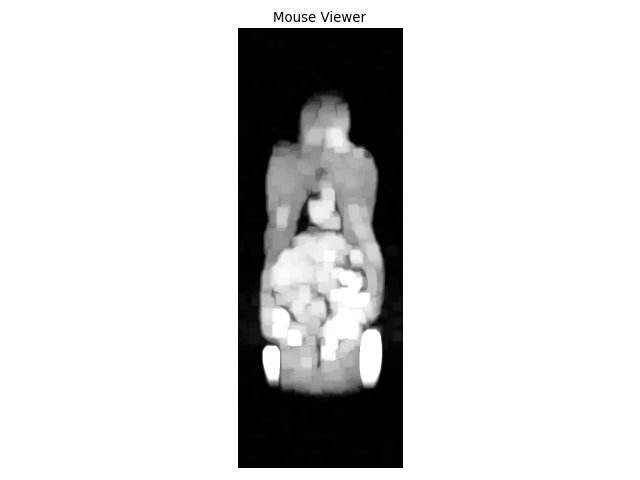

In [165]:
gui.MultiImageDisplay(image_list=[filtered_image], title_list=['Mouse Viewer'], figure_size=(8,6))

## Teste com imagens binarizadas

Para tentar melhorar ainda mais o resultado final do mesh, como o processo de impressão não ve os níveis ou dureza dos tecidos, apenas se há ou não material a ser depositado no local, tentamos fazer uma conversão binária na imagem, transformando todos os pixels maiores que 0 em 255.

In [166]:
!rd /s /q "binary_images/"
!mkdir binary_images

In [167]:
def binarize_image(pixel_array, threshold=0):
    pixel_array = np.array(pixel_array)
    pixel_array[pixel_array<=threshold] = 0
    pixel_array[pixel_array>threshold] = 255
    return pixel_array

In [168]:
binary_path = "binary_images/"

for file in os.listdir(filter_path):
    f = os.path.join(filter_path, file)
    if os.path.isfile(f):
        ds = dcmread(f)
        binary_image = intensity_filter(ds.pixel_array)
        binary_image = erosion(binary_image)
        binary_image = dilatation(binary_image)
        binary_image = noise_filter(binary_image)
        binary_image = binarize_image(binary_image)
        
        save_dicom_file(ds, binary_image, os.path.join(binary_path, file))

In [169]:
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(binary_path)
reader.SetFileNames(dicom_names)
binary_image = reader.Execute()

size = binary_image.GetSize()
size

(192, 512, 120)

<IPython.core.display.Javascript object>


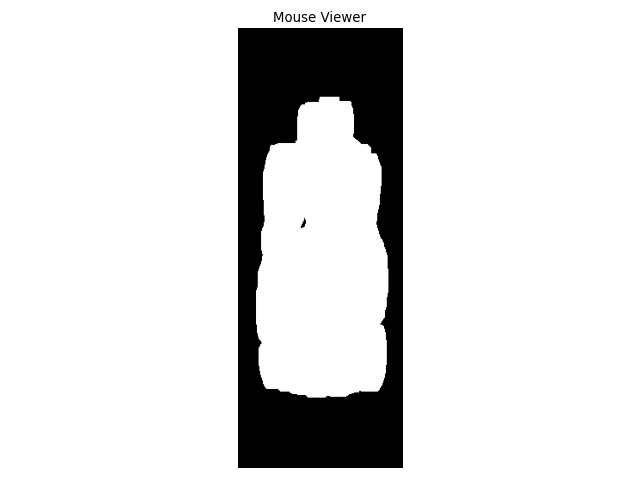

In [170]:
gui.MultiImageDisplay(image_list=[binary_image], title_list=['Mouse Viewer'], figure_size=(8,6))

## Gerando o mesh e o arquito STL

Para o processo de geração do arquito STL, utilizamos a implementação encontrada no git https://github.com/dave3d/dicom2stl.
<p>Como a implementação utiliza como entrada uma imagem com a extensão nii.gz, fazemos a conversão dos dados que tinhamos para esse formato e com o auxilio das bibliotecas sitk e itkwidgets conseguimos ja visualizar a forma do rato em 3D, mas ainda sem gerarmos o mesh e o STL.<p>
Para fins de comparação, utilizamos a função implementada para geração do primeiro STL, com os parâmetros padrões e recomendados na documentação e posteriormente, fomos testando novos parâmetros e valores, principalmente no que diz respeito a suavização da forma, para gerar uma superfície mais natural no objeto, o que nos leva ao resultado final.


# Modelo Original

In [185]:
sitk.WriteImage(original_image, "mouse.nii.gz")

In [186]:
#Set limits to x and y for a good view
mouse = sitk.ReadImage("mouse.nii.gz")
itkwidgets.view(mouse)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

In [187]:
!python dicom2stl/dicom2stl.py -i 90 -o mouse.stl mouse.nii.gz


Temp dir: Not specified, will use system temporary directory
Isovalue =  90.0
File names:  ['mouse.nii.gz'] 

Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.012 seconds
Surface extracted
     1236596 polygons
     0.242 seconds
Surface cleaned
     1236596 polygons
     0.45 seconds
Small parts cleaned
     735408 polygons
     0.761 seconds
Surface smoothed
     735408 polygons
     2.404 seconds
Surface reduced
     73540 polygons
     6.0520000000000005 seconds
Writing 73540 polygons to mouse.stl
writeSTL 1
Output mesh: mouse.stl



In [188]:
mesh = vtkutils.readMesh('mouse.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse.stl


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Modelo Binarizado

In [171]:
sitk.WriteImage(binary_image, "mouse_binary.nii.gz")

In [172]:
#Set limits to x and y for a good view
mouse = sitk.ReadImage("mouse_binary.nii.gz")
itkwidgets.view(mouse)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

In [173]:
!python dicom2stl/dicom2stl.py -i 90 -o mouse_binary.stl mouse_binary.nii.gz


Temp dir: Not specified, will use system temporary directory
Isovalue =  90.0
File names:  ['mouse.nii.gz'] 

Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.01 seconds
Surface extracted
     222072 polygons
     0.1 seconds
Surface cleaned
     222072 polygons
     0.061 seconds
Small parts cleaned
     219800 polygons
     0.11 seconds
Surface smoothed
     219800 polygons
     0.487 seconds
Surface reduced
     21980 polygons
     1.184 seconds
Writing 21980 polygons to mouse.stl
writeSTL 1
Output mesh: mouse.stl



In [174]:
mesh = vtkutils.readMesh('mouse_binary.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse.stl


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [175]:
!python dicom2stl/dicom2stl.py --help

usage: dicom2stl.py [-h] [--verbose] [--debug] [--output OUTPUT] [--meta META]
                    [--ct] [--clean] [--temp TEMP] [--search SEARCH]
                    [--type {skin,bone,soft_tissue,fat}] [--anisotropic]
                    [--isovalue ISOVALUE] [--double DOUBLE_THRESHOLD]
                    [--largest] [--rotaxis {X,Y,Z}] [--rotangle ROTANGLE]
                    [--smooth SMOOTH] [--reduce REDUCE] [--clean-small SMALL]
                    [--enable {anisotropic,shrink,median,largest,rotation}]
                    [--disable {anisotropic,shrink,median,largest,rotation}]
                    [filenames [filenames ...]]

positional arguments:
  filenames

optional arguments:
  -h, --help            show this help message and exit
  --verbose, -v         Enable verbose messages
  --debug, -D           Enable debugging messages
  --output OUTPUT, -o OUTPUT
                        Output file name (default=result.stl)
  --meta META, -m META  Output metadata file
  --ct    

In [176]:
!python dicom2stl/dicom2stl.py -a -i 90 -t soft_tissue -l --smooth 100 --reduce 0.6 -x 0.1 -o mouse_binary_2.stl mouse_binary.nii.gz


Temp dir: Not specified, will use system temporary directory
Tissue type:  soft_tissue
Isovalue =  90.0
File names:  ['mouse.nii.gz'] 

Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.01 seconds
Anisotropic Smoothing
     3.491 seconds
Median filter
     -12.649000000000001 seconds
Surface extracted
     202016 polygons
     0.1 seconds
Surface cleaned
     201940 polygons
     0.10300000000000001 seconds
Small parts cleaned
     201940 polygons
     0.099 seconds
Surface smoothed
     201940 polygons
     1.6380000000000001 seconds
Surface reduced
     80776 polygons
     0.736 seconds
Writing 80776 polygons to mouse_2.stl
writeSTL 1
Output mesh: mouse_2.stl



In [177]:
mesh = vtkutils.readMesh('mouse_binary_2.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse_2.stl


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Modelo final  

In [178]:
sitk.WriteImage(filtered_image, "mouse_filtered.nii.gz")

In [179]:
#Set limits to x and y for a good view
mouse = sitk.ReadImage("mouse_filtered.nii.gz")
itkwidgets.view(mouse)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

In [180]:
!python dicom2stl/dicom2stl.py -i 90 -o mouse_filtered.stl mouse_filtered.nii.gz


Temp dir: Not specified, will use system temporary directory
Isovalue =  90.0
File names:  ['mouse_filtered.nii.gz'] 

Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.012 seconds
Surface extracted
     250164 polygons
     0.10400000000000001 seconds
Surface cleaned
     250164 polygons
     0.067 seconds
Small parts cleaned
     236410 polygons
     0.127 seconds
Surface smoothed
     236410 polygons
     0.5720000000000001 seconds
Surface reduced
     23640 polygons
     1.389 seconds
Writing 23640 polygons to mouse_filtered.stl
writeSTL 1
Output mesh: mouse_filtered.stl



In [181]:
mesh = vtkutils.readMesh('mouse_filtered.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse_filtered.stl


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [182]:
!python dicom2stl/dicom2stl.py -a -i 70  -t soft_tissue -l --smooth 50 --reduce .1 -x 0.1 -o mouse_filtered_2.stl mouse_filtered.nii.gz


Temp dir: Not specified, will use system temporary directory
Tissue type:  soft_tissue
Isovalue =  70.0
File names:  ['mouse_filtered.nii.gz'] 

Shrink factors:  [1, 2, 1]
(192, 512, 120) -> (192, 256, 120)
     0.01 seconds
Anisotropic Smoothing
     3.494 seconds
Median filter
     -13.533 seconds
Surface extracted
     190948 polygons
     0.095 seconds
Surface cleaned
     182630 polygons
     0.09 seconds
Small parts cleaned
     182630 polygons
     0.08600000000000001 seconds
Surface smoothed
     182630 polygons
     0.725 seconds
Surface reduced
     164366 polygons
     0.194 seconds
Writing 164366 polygons to mouse_filtered_2.stl
writeSTL 1
Output mesh: mouse_filtered_2.stl



In [183]:
mesh = vtkutils.readMesh('mouse_filtered_2.stl')
itkwidgets.view(mesh, geometries=[mesh])

Input mesh: mouse_filtered_2.stl


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## Impressão 3D e Resultados Finais

Com o arquivo STL gerado, imprimimos o phantom em uma impressora Ender 3, utilizando PLA como material.

<img src="img/mouse.jpg" width=600 height=600 />

In [189]:
%%HTML
<video width="600" height="500" controls>
  <source src="img/gif.mp4" type="video/mp4">
</video>